In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 100 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 21.99 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=76f07e7647a358b1ce51102bb5bd0c7a652db333ef05e45c37c4c8e022d57c27
  Stored in directory: /tmp/pip-ephem-wheel-cache-hz_kpti1/wheels/55/59/29/0fb1c635652

In [2]:
from dul_2021.utils.hw12_utils import *

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [14]:
class Net(nn.Module):
    def __init__(self, input_dim=3, out_dim=10, hid_dim=128):
        super(Net, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, 32, 3, 1, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Flatten(start_dim=1)
        )

        self.linear = nn.Sequential(
            nn.Linear(4 * 4 * 128, hid_dim), 
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim), 
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )        

    def forward(self, x):
        return self.linear(self.conv(x))

In [18]:
class VAT(nn.Module):
    def __init__(self, xi=10.0):
        super().__init__()
        self.model = Net()
        self.xi = xi

        self.dist = torch.distributions.Normal(
            torch.zeros((3, 32, 32), device=device),
            torch.ones((3, 32, 32), device=device)
            )   

    def predict(self, x):
        return F.log_softmax(self.model(x), dim=1)  
        
    def get_loss(self, x, y):
        mask = y != -1

        prediction = self.model(x[mask])
        l_1 = F.cross_entropy(prediction, y[mask], reduction="none").mean()

        with torch.no_grad():
            target = F.softmax(self.model(x), dim=1)
         
        r = self.xi * F.normalize(self.dist.sample((x.shape[0],)), dim=(1,2,3))
        r.requires_grad_()

        kl_div = F.kl_div(self.predict(x + r), target, reduction="batchmean")
        kl_div.backward()

        r_adv = F.normalize(r.grad, dim=(1,2,3))
        self.zero_grad()

        l_2 = F.kl_div(self.predict(x + r_adv), target, reduction="batchmean")

        return (l_1 + l_2).mean() 

    def get_acc(self, loader):
        s_1, s_2 = 0, 0
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            mask = y != -1

            prediction = self.model(x[mask])
            acc = (torch.argmax(prediction, dim=1) == y[mask]).sum() 
            s_1 += (y != -1).sum().item()
            s_2 += acc.item()
        return s_2 / s_1
               

    def fit(self, train_loader, test_loader, num_epochs=15, lr=5e-4):

        optim = Adam(self.parameters(), lr=lr)
        losses, accuracies = [], []
        
        for _ in tqdm(range(num_epochs)):
            for batch in train_loader:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                loss = self.get_loss(x, y)

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())

            accuracies.append(self.get_acc(test_loader))
                
        return losses, accuracies    

In [21]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

    model = VAT().to(device)
    losses, accuracies = model.fit(train_loader, test_loader, num_epochs=15, lr=5e-4)

    return np.array(losses), np.array(accuracies)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

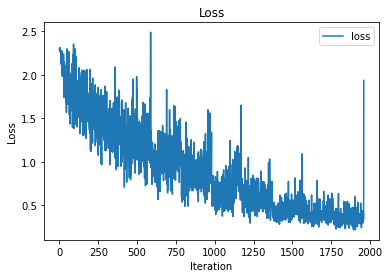

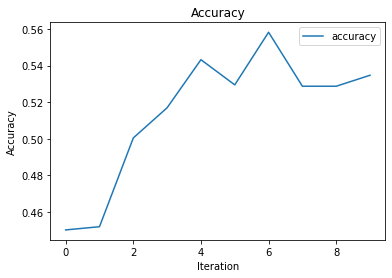

In [20]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
class FixMatch(nn.Module): 
    def __init__(self, tau=0.7, lambda_u=10.0): 
        super().__init__()

        self.model = Net()
        self.tau = tau
        self.lambda_u = lambda_u

        self.transform_strong = transforms.Compose(
            [
             transforms.RandomHorizontalFlip(),
             transforms.RandomResizedCrop(32),
             transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
             transforms.RandomGrayscale(0.2),
             transforms.GaussianBlur(9),
             transforms.Normalize(0.5, 0.5)
            ]
        )

        self.transform_weak = transforms.Compose(
            [
             transforms.RandomHorizontalFlip(),
             transforms.Normalize(0.5, 0.5)    
             ]
        )

        
    def get_loss(self, x, y):
        pass

    def get_acc(self, loader):
        s_1, s_2 = 0, 0
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            mask = y != -1

            prediction = self.model(x[mask])
            acc = (torch.argmax(prediction, dim=1) == y[mask]).sum() 
            s_1 += (y != -1).sum().item()
            s_2 += acc.item()
        return s_2 / s_1
               

    def fit(self, train_loader, test_loader, num_epochs=20, lr=5e-4):

        optim = Adam(self.parameters(), lr=lr)

        losses, accuracies = [], []
        for _ in tqdm(range(num_epochs)):
            for batch in train_loader:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                loss = self.get_loss(x, y)

                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())

            accuracies.append(self.get_acc(test_loader))
                
        return losses, accuracies          

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

In [ ]:
q_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """